# Lagrangian Simulation of Marine Debris Movement

This Jupyter notebook is designed to model and simulate the movement of marine debris around the coast of Malta, using the OceanParcels framework. The process involves a series of steps starting with importing necessary libraries, preparing datasets, and setting up the simulation environment, followed by initializing particle positions, defining custom behavior through kernels, executing the simulation, and finally visualizing the results.

The objective is to understand how marine debris, represented by particles in the simulation, moves under the influence of ocean currents and wind. This notebook aims to provide insights into the dispersion patterns of debris in marine environments, which is critical for environmental studies and conservation efforts.

### Importing Necessary Libraries

In [1]:
from datetime import timedelta
import math

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
from rasterio.features import rasterize
import xarray as xr
from IPython.display import HTML
from matplotlib.animation import FuncAnimation

from parcels import (
    AdvectionRK4,
    Field,
    FieldSet,
    JITParticle,
    ParticleFile,
    ParticleSet,
    StatusCode,
    Variable,
)
import parcels.rng as ParcelsRandom

### Verifying the structure and dimentions of the data files

Before proceeding with the simulation, it's crucial to inspect the structure and dimensions of the datasets involved. This section opens and prints the metadata of the Sea Surface Current (SSC) and the Wind datasets, providing an understanding of their structure, variables, and dimensions. It ensures that the datasets are correctly formatted and suitable for use in the simulation.

In [2]:
# Open the SSC dataset
ssc_ds = xr.open_dataset("Data/Processed_SSC_Data.nc")

# Print the SSC dataset
print("SSC Dataset:\n")
print(ssc_ds)
print("=" * 125)

# Open the wind dataset
wind_ds = xr.open_dataset("Data/Processed_Wind_Data.nc")

# Print the wind dataset
print("\nWind Dataset:\n")
print(wind_ds)
print("=" * 125)

# Close datasets after inspection
ssc_ds.close()
wind_ds.close()

SSC Dataset:

<xarray.Dataset>
Dimensions:  (time: 72, lat: 52, lon: 43)
Coordinates:
  * time     (time) datetime64[ns] 2023-01-01 ... 2023-01-03T23:00:00
  * lat      (lat) float32 35.74 35.77 35.79 35.81 ... 36.81 36.84 36.86 36.88
  * lon      (lon) float32 13.68 13.72 13.76 13.8 ... 15.26 15.3 15.34 15.38
Data variables:
    u        (time, lat, lon) float64 ...
    v        (time, lat, lon) float64 ...
    stdu     (time, lat, lon) float64 ...
    stdv     (time, lat, lon) float64 ...
    cov      (time, lat, lon) float64 ...
    velo     (time, lat, lon) float64 ...
    head     (time, lat, lon) float64 ...
Attributes: (12/17)
    NC_GLOBAL.Title:                   Near-Real time Surface Ocean Velocity
    NC_GLOBAL.origin:                  MRAG (measured);LICA (measured);SOPU (...
    NC_GLOBAL.source:                  HF Radar Derived Surface Currents obta...
    NC_GLOBAL.history:                 08-Jun-2023 19:17:47
    NC_GLOBAL.grid_type:               REGULAR
    NC_GLOBA

### Loading shapefile and extracting coastline boundaries

The coastline boundaries are essential for defining the simulation area and implementing land-sea interactions. This section loads a shapefile representing Malta's coastline and visualizes the coastline. This shapefile is crucial for the creation of the land sea mask in the next step.

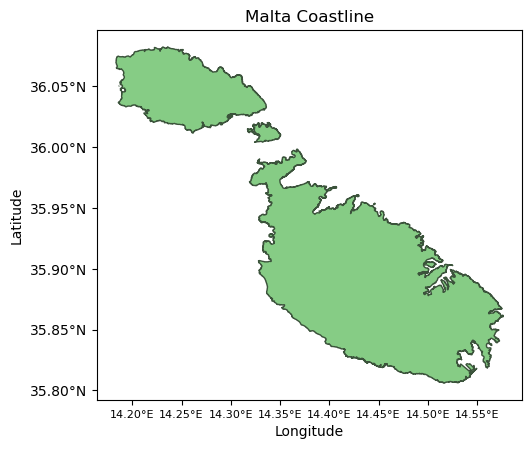

In [3]:
# Load the shapefile
shapefile_path = 'Data/land_sea_mask/MaltaCoastline.shp'
gdf = gpd.read_file(shapefile_path)

# Convert the GeoDataFrame to WGS 84 CRS if it's not already
gdf = gdf.to_crs(epsg=4326)

# Plot the shapefile with latitude and longitude labels
gdf.plot(color='#86CC85', edgecolor='#3B533B')
plt.title('Malta Coastline')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Format the axis labels to show degrees
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda val, pos: '{:.2f}°E'.format(val)))
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda val, pos: '{:.2f}°N'.format(val)))

# Make the x-axis tick labels smaller
plt.gca().tick_params(axis='x', labelsize=8)  

plt.show()

### Createing the Land-Sea Mask

A high-resolution land-sea mask is generated by rasterizing the coastline shapefile. This mask distinguishes between land and sea areas, allowing for accurate particle tracking near coastal regions. The mask is saved as a NetCDF file and visualized to verify its correctness. This preparation is vital for the simulation, as it influences particle behavior at the land-sea interface.

The visualization displays the land-sea mask with dark purple indicating sea areas (0) and red with a white outline denoting land areas (1).

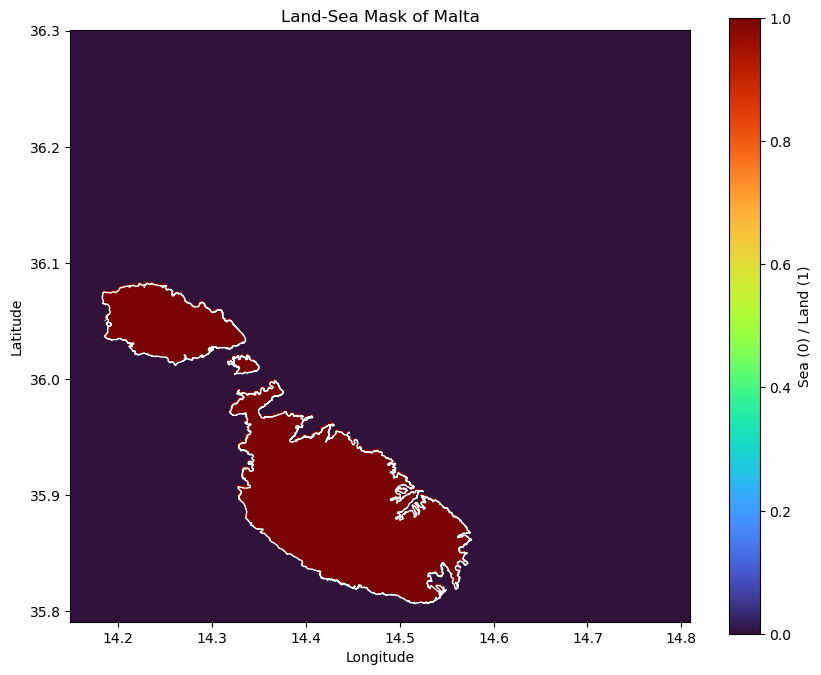

In [4]:
# Reproject to geographic coordinates (WGS 84)
gdf = gdf.to_crs(epsg=4326)

# Simulation bounds
lon_min, lat_min, lon_max, lat_max = 14.15, 35.79, 14.81, 36.3

# Define a fine resolution in kilometers
resolution_km = 0.1 

# Calculate the distance in degrees for the given resolution
mean_lat = (lat_min + lat_max) / 2
# Calculate the approximate conversion factor at this latitude
km_per_degree = np.cos(mean_lat * np.pi / 180) * 111.32  
resolution_degrees = resolution_km / km_per_degree

# Calculate the number of grid cells at this new resolution
num_lons = int(np.ceil((lon_max - lon_min) / resolution_degrees))
num_lats = int(np.ceil((lat_max - lat_min) / resolution_degrees))

# Create the transformation from lat/lon to the grid
transform = rasterio.transform.from_origin(lon_min, lat_max, resolution_degrees, resolution_degrees)

# Rasterize the shapefile
raster = rasterize(
    [(geom, 1) for geom in gdf.geometry],
    out_shape=(num_lats, num_lons),
    transform=transform,
    fill=0,  # Fill value for 'sea'
    all_touched=True
)

# Generate the grid of longitude and latitude values
lons = np.linspace(lon_min, lon_max, num_lons, endpoint=False)
lats = np.linspace(lat_max, lat_min, num_lats, endpoint=False)[::-1]  # Start from max latitude to min latitude

# Create an xarray Dataset for the land-sea mask
ds = xr.Dataset(
    {
        'land_sea_mask': (['lat', 'lon'], raster)
    },
    coords={
        'lon': lons,
        'lat': lats  
    }
)

# Save the dataset to a NetCDF file
nc_filename = "Data/land_sea_mask/land_sea_mask_malta.nc"
ds.to_netcdf(nc_filename)

# Plot the land-sea mask for verification
plt.figure(figsize=(10, 8))
plt.pcolormesh(lons, lats[::-1], raster, cmap='turbo')
plt.colorbar(label='Sea (0) / Land (1)')
plt.title('Land-Sea Mask of Malta')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Overlay the shapefile to verify alignment
gdf.plot(ax=plt.gca(), color='none', edgecolor='white')

plt.show()

### Creating a FieldSet

A `FieldSet` is created from the sea surface current and wind datasets. It serves as the simulation environment, defining the velocity fields that drive particle movement. The land-sea mask is also incorporated into the FieldSet as an additional field, providing the necessary data for reflecting or deleting particles upon reaching the coastline.

In [5]:
fieldset = FieldSet.from_netcdf(
    filenames={
        "U": "Data/Processed_SSC_Data.nc",
        "V": "Data/Processed_SSC_Data.nc",
        "U_wind": "Data/Processed_Wind_Data.nc",
        "V_wind": "Data/Processed_Wind_Data.nc"
    },
    variables={
        "U": "u",
        "V": "v",
        "U_wind": "u10",
        "V_wind": "v10"
    },
    dimensions={
        "U": {"lon": "lon", "lat": "lat", "time": "time"},
        "V": {"lon": "lon", "lat": "lat", "time": "time"},
        "U_wind": {"lon": "longitude", "lat": "latitude", "time": "time"},
        "V_wind": {"lon": "longitude", "lat": "latitude", "time": "time"}
    },
    allow_time_extrapolation=True
)

# Load the land-sea mask data
landsea_data = xr.open_dataset("Data/land_sea_mask/land_sea_mask_malta.nc")

# Add the land-sea mask as a Field to the FieldSet
fieldset.add_field(Field('land_sea_mask', 
                         data=landsea_data['land_sea_mask'].values, 
                         lon=landsea_data['lon'].values, 
                         lat=landsea_data['lat'].values, 
                         mesh='spherical', 
                         interp_method='nearest'))

### Initializing the Particles

Particles are initialized near a specified location with random offsets to simulate a dispersed release. The section also plots the initial positions of these particles on the map, to show where they will be initialised exactly. The particles represent the objects of interest, such as sea surface debris, whose movements are to be simulated.

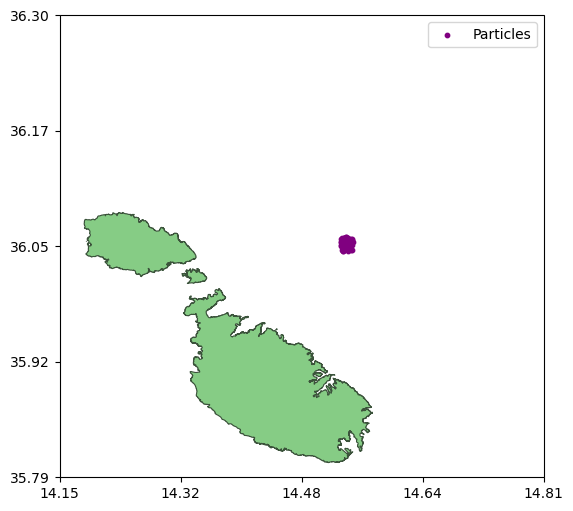

In [6]:
# Number of particles
num_particles = 50

# Center start point for all particles
start_lat = 36.0475
start_lon = 14.5417

# Define a small range for the random offset
offset_range = 0.008  

# Generate random offsets for longitude and latitude
lon_offsets = np.random.uniform(-offset_range, offset_range, num_particles)
lat_offsets = np.random.uniform(-offset_range, offset_range, num_particles)

# Apply offsets to the starting point
lon_release = start_lon + lon_offsets
lat_release = start_lat + lat_offsets

# Define the geographic boundaries for the plot a bit smaller than dataset boundaries
extent = [14.15, 14.81, 35.79, 36.3]

# Prepare the plot
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent(extent)

# Plot the shapefile for Malta's coastline
gdf.plot(ax=ax, color='#86CC85', edgecolor='#3B533B', linewidth=0.8, zorder=2)

# Plot the particles
scatter = ax.scatter(lon_release, lat_release, s=10, c="purple", marker='o', transform=ccrs.PlateCarree(), label='Particles')

# Define ticks for longitude and latitude based on the extent
lon_ticks = np.linspace(extent[0], extent[1], num=5) # 5 ticks along longitude
lat_ticks = np.linspace(extent[2], extent[3], num=5) # 5 ticks along latitude

# Set ticks
ax.set_xticks(lon_ticks, crs=ccrs.PlateCarree())
ax.set_yticks(lat_ticks, crs=ccrs.PlateCarree())

# Set tick labels
ax.set_xticklabels([f'{tick:.2f}' for tick in lon_ticks])
ax.set_yticklabels([f'{tick:.2f}' for tick in lat_ticks])

plt.legend()
plt.show()

### Define Simulation Parameters

This brief section specifies the simulation's runtime and timestep. These parameters determine the duration of the simulation and the frequency at which the particles' positions are updated.

In [7]:
# Define number of days for the simulation
runtime = timedelta(days=3)  

# Timestep that aligns with the data intervals
dt = timedelta(minutes=10)

### Custom kernels & executing the simulation

Custom kernels are defined to implement specific behaviors during the simulation, such as checking for out-of-bounds conditions and reflecting particles at the coastline. The simulation is then executed with these kernels, and the output is saved for subsequent visualization. This step combines the prepared environment, particle initialization, and custom behaviors to simulate the Lagrangian particle movement.

In [12]:
def CheckOutOfBounds(particle, fieldset, time):
    if particle.state == StatusCode.ErrorOutOfBounds:
        particle.delete()

def CheckError(particle, fieldset, time):
    # This captures all Errors
    if particle.state >= 50:  
        particle.delete()
        
class ReflectiveParticle(JITParticle):
    # Adding variables for previous positions
    # Initialize with the first longitude 
    prev_lon = Variable('prev_lon', initial=fieldset.U.grid.lon[0])  
    # Initialize with the first latitude 
    prev_lat = Variable('prev_lat', initial=fieldset.U.grid.lat[0])  
    # Elapsed time in seconds
    elapsed_time = Variable('elapsed_time', initial=0.)  
    
# Custom kernel to update the elapsed time
def UpdateElapsedTime(particle, fieldset, time):
    particle.elapsed_time += math.fabs(particle.dt) / (3600 * 24)  # Convert seconds to days
    
def UpdatePreviousPosition(particle, fieldset, time):
    # Update the previous position with the current position before moving
    particle.prev_lon = particle.lon
    particle.prev_lat = particle.lat
    
def ReflectOnLand(particle, fieldset, time):
    if fieldset.land_sea_mask[particle] == 1:
        # Generate a random number between 0 and 1 using Parcels' RNG
        random_number = ParcelsRandom.random()

        # Define the probability of a particle being beached
        beaching_probability = 0.15  # 15% chance
        
        if random_number < beaching_probability:
            # If the random number is less than the beaching probability, delete the particle
            particle.delete()
        else:
            # Otherwise, reflect the particle's position
            particle.lon = particle.prev_lon
            particle.lat = particle.prev_lat
               
# Create a ParticleSet with JITParticle positioned near the edges
pset = ParticleSet(fieldset=fieldset, pclass=ReflectiveParticle, lon=lon_release, lat=lat_release)

# Execute the simulation
output_file = pset.ParticleFile(name="Lagrangian_Output/debris_simulation_output.zarr", outputdt=timedelta(minutes=10))

pset.execute(
    AdvectionRK4+
    pset.Kernel(UpdatePreviousPosition) + 
    pset.Kernel(ReflectOnLand) +
    pset.Kernel(UpdateElapsedTime) +
    pset.Kernel(CheckOutOfBounds) + 
    pset.Kernel(CheckError),
    runtime=runtime,
    dt=dt,
    output_file=output_file,
)  

print("="*175)

INFO: Output files are stored in Lagrangian_Output/debris_simulation_output.zarr.
100%|██████████| 259200.0/259200.0 [00:34<00:00, 7458.59it/s]


### Visualising the particle dispertion

The output of the simulation is visualized to assess the movement and dispersion of particles over time. This visualization provides insights into the particles' trajectories and how they interact with the environment, particularly in response to ocean currents and wind. This is saved as a GIF file, providing a dynamic and accessible way to observe the simulated dispersion over time.

In [9]:
# Load the simulation output
ds = xr.open_zarr("Lagrangian_Output/debris_simulation_output.zarr")

# Load the shapefile with the map of Malta
malta_map = gpd.read_file('Data/land_sea_mask/MaltaCoastline.shp')
malta_map = malta_map.to_crs(epsg=4326)

# Define the geographic boundaries for the plot a bit smaller than dataset boundaries 
extent = [14.15, 14.71, 35.79, 36.2]

# Turn off interactive plotting
plt.ioff()

#warnings.filterwarnings('ignore', 'invalid value encountered in cast')

# Prepare the plot
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent(extent)

# Add the map of Malta
malta_map.plot(ax=ax, color='#86CC85', edgecolor='#3B533B', linewidth=0.8, zorder=2)

# Add other map features
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Define and set custom tick labels without degrees for longitude and latitude
lon_ticks = np.linspace(extent[0], extent[1], 5) 
lat_ticks = np.linspace(extent[2], extent[3], 5) 

ax.set_xticks(lon_ticks, crs=ccrs.PlateCarree())
ax.set_yticks(lat_ticks, crs=ccrs.PlateCarree())

ax.set_xticklabels([f"{lon:.2f}" for lon in lon_ticks])
ax.set_yticklabels([f"{lat:.2f}" for lat in lat_ticks])

# Add labels to the x and y axes
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Initialize scatter plot with empty data
scatter = ax.scatter([], [], s=1, c="purple", marker='o', transform=ccrs.PlateCarree())

# Initialize a text element to display the number of days passed
day_text = ax.text(0.01, 0.95, '', transform=ax.transAxes, color='black')

simulation_start_date = pd.to_datetime('2023-01-01')

# Initialize a text element at the figure level to display the number of days passed
day_text = fig.text(0.5, 0.95, '', ha='center', va='center', fontsize='large', color='black')

# Function to update the scatter plot and text at each frame
def update(frame):
    time_step_data = ds.isel(obs=frame)
    scatter.set_offsets(np.vstack((time_step_data.lon.values, time_step_data.lat.values)).T)
    
    # Calculate the number of days since the start of the simulation
    current_time_str = time_step_data.time.values[0]  
    current_time = pd.to_datetime(current_time_str)
    num_days = (current_time - simulation_start_date).days + 1 
    day_text.set_text(f"Day: {num_days}")  

    return scatter, day_text

# Adjust the frames parameter to ensure each frame represents one day
total_days = ds.sizes['obs'] 

# Create animation
ani = FuncAnimation(fig, update, frames=total_days, interval=100, blit=False)

# Set limit for the animation (in MB)
mpl.rcParams['animation.embed_limit'] = 300

# To save the animation as a GIF file
ani.save('Lagrangian_Output/particle_trajectories.gif', writer='pillow')

### Animation of the particle movement

Finally, an animation is created to dynamically represent the particles' trajectories over the simulation period. This visualization offers an engaging way to observe and understand the simulated movements of marine debris or other particles within the marine environment.

In [10]:
HTML(ani.to_jshtml())